# Natural Computing

## Exercises on Evolutionary Computation

In [1]:
import tsplib95 # pip install tsplib95
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from operator import itemgetter
import time
from tqdm import tqdm
%matplotlib inline

## Exercise 6

#### Simple EA for TSP:
- Random initialization of the population
- Binary tournament selection (results in mating pool)
- Generational gap replacement strategy (10% elitism: 10% of worst offspring replaced by best current parents)
- Fixed size population

### Utility functions

In [2]:
# List of tuples representing edges for plotting
def get_edge_list(tour):
    edge_list = []
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        edge_list.append( (a, b) )
    # close tour
    edge_list.append( (tour[-1], tour[0]) )
    return edge_list

# Plot tour including performance
def plot_tour(tour, distance, problem):
    edge_list = get_edge_list(tour)
    nx.draw_networkx(problem.get_graph(), 
                     pos=problem.node_coords, 
                     edgelist=edge_list, 
                     node_size=50,
                     with_labels=False
                    )
    plt.title(f"{problem.name} ({distance})")
    plt.show()

In [3]:
# Get best and worst tour, and average tour distance in population
def population_stats(population):
    best = min(population, key=itemgetter(1))
    worst = max(population, key=itemgetter(1))
    avg = np.mean([tour[1] for tour in population])
    return best, worst, avg

# Summary of a population
def track_progress(problem, population, gen_id):
    # get population statistics
    best, worst, avg = population_stats(population)
    # print statistics
    print('='*5, f"Generation {gen_id}", '='*5)
    print("Best: ", best[1])
    print("Worst: ", worst[1])
    print("Average: ", avg)
    # plot the best tour
    plot_tour(best[0], best[1], problem)

In [4]:
def plot_history(generations, solution_dist):
    best_scores = [best[1] for best, _, _ in generations]
    worst_scores = [worst[1] for _, worst, _ in generations]
    avg_scores = [avg for _, _, avg in generations]
    
    nr_of_generations = len(generations)
    x_range = range(nr_of_generations)
    plt.figure(figsize=(12, 8))
    plt.plot(x_range, best_scores, label = "best distance")
    plt.plot(x_range, worst_scores, label = "worst distance")
    plt.plot(x_range, avg_scores, label = "avg distance")
    plt.plot(x_range, [solution_dist]*nr_of_generations, label = "optimal distance")
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.title("Evolution over generations", size=14)
    plt.legend()
    plt.show()

### Evolutionary Algorithm

In [5]:
def init_population(problem, size):
    nodes = list(problem.get_nodes())
    population = [np.random.permutation(nodes) for _ in range(size)]
    population = [(list(tour), total_distance(tour, problem)) for tour in population] # tuple(tour, distance)
    return population

In [6]:
# Fitness function
def total_distance(tour, problem):
    total_dist = 0
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        dist = problem.wfunc(a, b)
        total_dist += dist
    # close tour
    total_dist += problem.wfunc(tour[-1], tour[0])
    return total_dist

In [7]:
# Binary tournament selection
def tournament(population):
    participants = random.sample(population, 2)
    winner = min(participants, key=itemgetter(1))
    return winner

In [8]:
def ordered_crossover(parent1, parent2):
    # choose two cut points
    length = len(parent1)
    pos1, pos2 = random.sample(range(length), 2)
    start_pos = min(pos1, pos2)
    end_pos = max(pos1, pos2)
    
    # slice between cut points
    child1 = parent1[start_pos:end_pos+1]
    child2 = parent2[start_pos:end_pos+1]
    
    # fill missing cities in order they appear in other parent
    missing_cities1 = [city for city in parent2 if city not in child1]
    missing_cities2 = [city for city in parent1 if city not in child2]
    
    # append missing cities starting from 2nd cut point
    child1 += missing_cities1
    child2 += missing_cities2
    return child1, child2

def mutation(tour):
    # shallow copy of original
    mutated_tour = tour[:]
    
    # choose two positions
    length = len(tour)
    pos1, pos2 = random.sample(range(length), 2)
    
    # reverse sequence mutation
    mutated_tour[pos1], mutated_tour[pos2] = mutated_tour[pos2], mutated_tour[pos1]
    return mutated_tour

In [9]:
def next_generation(problem, mating_pool, size, p_c, p_m):
    new_population = []
    while len(new_population) < size:
        # select two parents from mating pool
        parent1, parent2 = random.sample(mating_pool, 2) 
        parent1, parent2 = parent1[0], parent2[0] # get tour            
        # initalize offspring to be equal to parent
        child1, child2 = parent1[:], parent2[:]

        # ordered crossover
        test_p_c = np.random.uniform()
        if test_p_c < p_c:
            child1, child2 = ordered_crossover(parent1, parent2)
                
        # mutation
        test_p_m = np.random.uniform()
        if test_p_m < p_m:
            child1, child2 = mutation(child1), mutation(child2)
            
        # add offspring to new population
        dist1 = total_distance(child1, problem)
        dist2 = total_distance(child2, problem)
        new_population += [ (child1, dist1), (child2, dist2) ]
    return new_population

In [10]:
def exert_elitism(population, new_population, size, elitism):
    # compute elite size
    elite = int(size * elitism)
    
    # drop worst tours from new population
    distances_new = [distance for _, distance in new_population]
    idx_drop = list(np.argpartition(distances_new, -elite))[-elite:]
    elite_population = [tour for i, tour in enumerate(new_population) if i not in idx_drop]
        
    # add elite (best tours) from current population to new population
    distances_old = [distance for _, distance in population]
    idx_elite = list(np.argpartition(distances_old, elite))[:elite]  
    elitists = [tour for i, tour in enumerate(population) if i in idx_elite]
    elite_population += elitists
    
    return elite_population

In [11]:
def EA_TSP(problem, size=100, nr_of_generations=200, p_c=0.9, p_m=0.2, elitism=0.1, plot_every=-1):
    # history
    generations = []
    
    # initialize population
    population = init_population(problem, size)
    if plot_every > 0:
        track_progress(problem, population, 1)
    
    for t in range(nr_of_generations):
        # tournament selection for mating pool
        mating_pool = [tournament(population) for _ in range(size)]
        
        # generate offspring for generational replacement
        new_population = next_generation(problem, mating_pool, size, p_c, p_m) 
        
        # elitism
        new_population = exert_elitism(population, new_population, size, elitism)    
        population = new_population
        
        generations.append(population_stats(population))
        
        # plot every so often to monitor progress
        if t % plot_every == plot_every-1:
            track_progress(problem, new_population, t+1)
        
    return generations

### Memetic Algorithm

Re-uses code from the Evolutionary Algorithm with some modifications to incorporate local search.

- Initialize the population of random candidate solutions
- Apply **LOCAL SEARCH** to each individual
- Evaluate the quality of each candidate
- Repeat until termination condition is satisfied:
    - Select parents for reproduction
    - Recombine selected parents
    - Mutate the resulting individuals
    - Apply **LOCAL SEARCH** to each individual
    - Evaluate the new candidates
    - Select individuals for the next generation

Peter Merz and Bernd Freisleben. “Memetic algorithms for the traveling salesman prob-lem”. In:Complex Systems13.4 (2001), pp. 297–346.:
- "The landscape analysis has shown that there is correlation between tour length and distance to the optimum of local minima and that a local optimum with high fitness (short tour length) is contained near other local optima with high fitness. Therefore, it makes sense to restrict a local search after recombination to search only the region around or between the two parents. This can be accomplished by fixing all common edges that have been included in the child in the first step of recombination. The edges that are common to both parents can be regarded as the “building blocks” of the evolutionary search and should be found in good offspring tours. Fixing these edges prevents the local search from replacing these edges by others and reduces the running time of the local search considerably. The fixing of edges reduces the problem size for the local search since fixed edges are not considered during the search for edge exchanges. After the local search has been terminated, all edges are marked as not fixed." 
- "The population size of an MA is typically small compared to GAs: a size of 10 up to 40 is common in an MA, since the computational complexity of the local search does not allow evolution of much larger populations within reasonable time."
- "The use of local search after the application of a recombination operator can compensate for the disruptive effects of implicit mutations. In some cases, implicit mutations have a positive effect on the performance of the local search, and in some situations they do not. Thus, it is important that implicit mutations can be controlled in some way"

In [12]:
def local_search(problem, candidate, depth=10):
    """
    Local search with edge exchange.
    Does not consider whole neighbor set,
    but only tries `depth` edge exchanges.
    """
    tour, dist = candidate
    length = len(tour)
    best_tour = tour
    best_dist = dist
    for _ in range(depth):
        # sample two positions
        pos1, pos2 = random.sample(range(length), 2) # indices
        while abs(pos1 - pos2) == 1: # sample again if positions are neighbors
            pos1, pos2 = random.sample(range(len(tour)), 2)
            
        # account for end of list
        pos1_next, pos2_next = pos1 + 1, pos2 + 1
        if pos1 == length-1:
            pos1_next = 0
        if pos2 == length-1:
            pos2_next = 0
        
        # edge exchange
        neighbor = tour[:] # shallow copy
        neighbor[pos1_next], neighbor[pos2] = neighbor[pos2], neighbor[pos1_next]
        neighbor_dist = total_distance(neighbor, problem)
        
        # store best neighbor tour and distance
        if neighbor_dist < best_dist:
            best_tour = neighbor
            best_dist = neighbor_dist
            
    return best_tour, best_dist

In [13]:
def next_generation_memetic(problem, mating_pool, size, p_c, p_m):
    new_population = []
    while len(new_population) < size:
        # select two parents from mating pool
        parent1, parent2 = random.sample(mating_pool, 2) 
        parent1, parent2 = parent1[0], parent2[0] # get tour            
        # initalize offspring to be equal to parent
        child1, child2 = parent1[:], parent2[:]

        # ordered crossover
        test_p_c = np.random.uniform()
        if test_p_c < p_c:
            child1, child2 = ordered_crossover(parent1, parent2)
                
        # mutation
        test_p_m = np.random.uniform()
        if test_p_m < p_m:
            child1, child2 = mutation(child1), mutation(child2)
            
        dist1 = total_distance(child1, problem)
        dist2 = total_distance(child2, problem)
        child1 = local_search(problem, (child1,dist1)) 
        child2 = local_search(problem, (child2,dist2)) 
            
        # add offspring to new population
        new_population += [ child1, child2 ]
    return new_population

In [32]:
def memetic_TSP(problem, size=40, nr_of_generations=200, p_c=0.9, p_m=0.2, elitism=0.1, plot_every=-1):
    # history
    generations = []
    
    # initialize population
    population = init_population(problem, size)
    # local search
    population = [local_search(problem, candidate) for candidate in population]
    if plot_every > 0:
        track_progress(problem, population, 1)
    
    for t in range(nr_of_generations):
        # tournament selection for mating pool
        mating_pool = [tournament(population) for _ in range(size)]
        
        # generate offspring for generational replacement with local search
        new_population = next_generation_memetic(problem, mating_pool, size, p_c, p_m) 
        
        # elitism
        new_population = exert_elitism(population, new_population, size, elitism)    
        population = new_population
        
        generations.append(population_stats(population))
        
        # plot every so often to monitor progress
        if t % plot_every == plot_every-1:
            track_progress(problem, new_population, t+1)
        
    return generations

### Main procedure

In [15]:
def load_TSP(problem_path, solution_path):
    problem = tsplib95.load_problem(problem_path)
    print("--- TSP problem information ---")
    print("Name: ", problem.name)
    print("Comment: ", problem.comment)
    print("Dimension: ", problem.dimension)
    print("Edge weight type: ", problem.edge_weight_type)
    
    solution = tsplib95.load_solution(solution_path)
    solution_dist = problem.trace_tours(solution)[0]
    print("Optimal solution: ", solution_dist)
    plot_tour(solution.tours[0], solution_dist, problem)
    
    return problem, solution

In [16]:
def main(problem, solution, n_gen):
    plot_every = n_gen / 5

    start = time.time()
    generations = EA_TSP(problem, 
                         nr_of_generations=n_gen, 
                         plot_every=plot_every)
    end = time.time()
    print("Elapsed time: {0:0.2f}s".format(end-start))
    
    solution_dist = problem.trace_tours(solution)[0]
    plot_history(generations, solution_dist)

In [17]:
def multiple_runs(problem, n_gen, n_runs=10):   
    best_in_runs = []
    for i in tqdm( range(n_runs) ):
        generations = EA_TSP(problem, 
                             nr_of_generations=n_gen)
        best = min( [best[1] for best, _, _ in generations] )
        best_in_runs.append(best)
    return best_in_runs

In [18]:
def main_memetic(problem, solution, n_gen):
    plot_every = n_gen / 5

    start = time.time()
    generations = memetic_TSP(problem, 
                         nr_of_generations=n_gen, 
                         plot_every=plot_every)
    end = time.time()
    print("Elapsed time: {0:0.2f}s".format(end-start))
    
    solution_dist = problem.trace_tours(solution)[0]
    plot_history(generations, solution_dist)

In [19]:
def multiple_runs_memetic(problem, n_gen, n_runs=10):   
    best_in_runs = []
    for i in tqdm( range(n_runs) ):
        generations = memetic_TSP(problem, 
                             nr_of_generations=n_gen)
        best = min( [best[1] for best, _, _ in generations] )
        best_in_runs.append(best)
    return best_in_runs

### TSP: berlin52

--- TSP problem information ---
Name:  berlin52
Comment:  52 locations in Berlin (Groetschel)
Dimension:  52
Edge weight type:  EUC_2D
Optimal solution:  7542


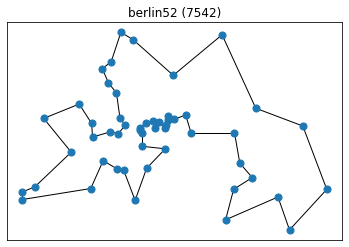

In [20]:
berlin52_problem, berlin52_solution = load_TSP('data/berlin52.tsp', 'data/berlin52.opt.tour')

**Evolutionary Algorithm**

===== Generation 1 =====
Best:  25840
Worst:  33917
Average:  29751.92


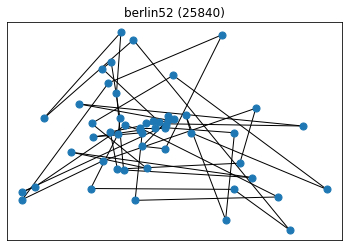

===== Generation 200 =====
Best:  10228
Worst:  13086
Average:  11289.65


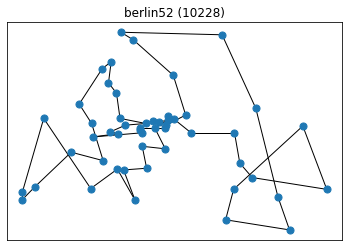

===== Generation 400 =====
Best:  8967
Worst:  11753
Average:  9978.16


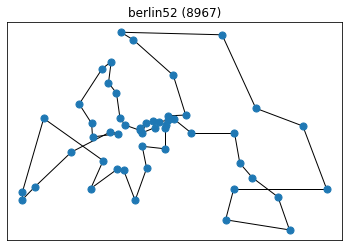

===== Generation 600 =====
Best:  8683
Worst:  12199
Average:  10109.44


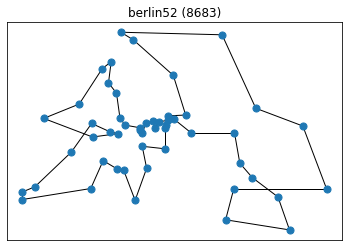

===== Generation 800 =====
Best:  8549
Worst:  12025
Average:  10107.71


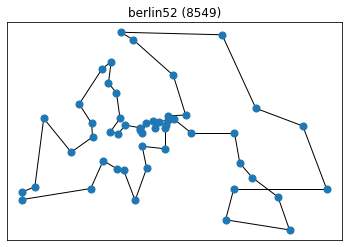

===== Generation 1000 =====
Best:  8321
Worst:  11994
Average:  10085.32


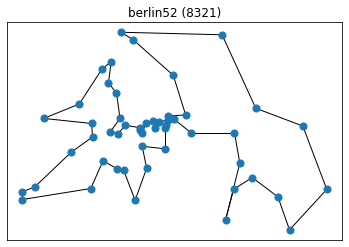

Elapsed time: 31.31s


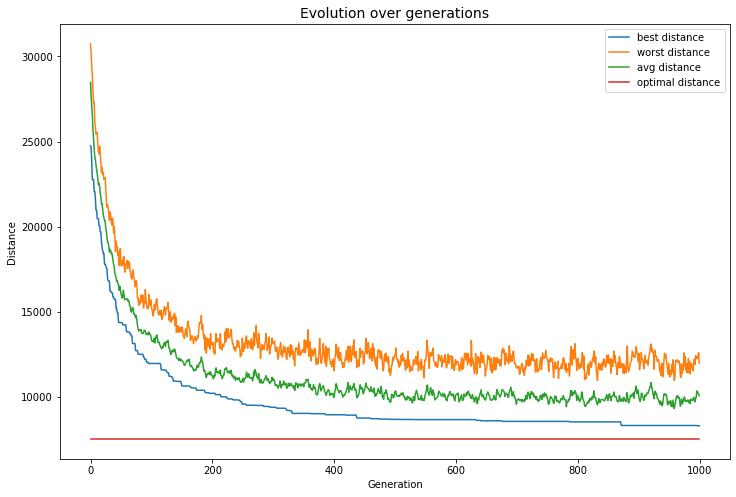

In [21]:
main(berlin52_problem, berlin52_solution, 1000)

In [22]:
# Run EA multiple times to account for variance between runs
berlin52_best = multiple_runs(berlin52_problem, 1000)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:37<00:00, 27.72s/it]


In [23]:
print("Best over runs:", berlin52_best)
print("Mean:", np.mean(berlin52_best))
print("Standard deviation:", np.std(berlin52_best))

Best over runs: [7770, 8369, 8769, 8308, 8371, 8149, 8331, 8624, 8102, 8018]
Mean: 8281.1
Standard deviation: 274.7036403107902


**Memetic**

Fewer generations are used because of run time and it seems that the memetic variant stagnates earlier anyway.

===== Generation 1 =====
Best:  25413
Worst:  31787
Average:  28829.5


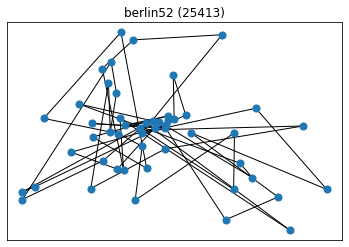

===== Generation 200 =====
Best:  9614
Worst:  12836
Average:  10886.13


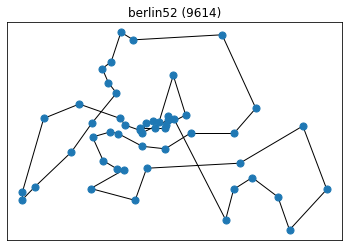

===== Generation 400 =====
Best:  8383
Worst:  11481
Average:  9658.66


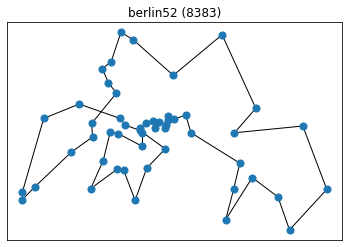

===== Generation 600 =====
Best:  8296
Worst:  11491
Average:  9885.92


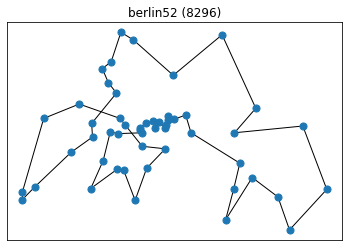

===== Generation 800 =====
Best:  8289
Worst:  11549
Average:  9752.49


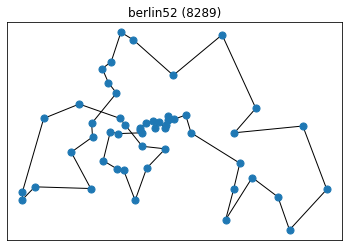

===== Generation 1000 =====
Best:  8289
Worst:  11206
Average:  9426.11


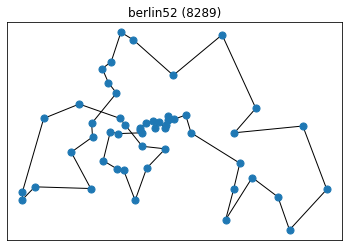

Elapsed time: 263.96s


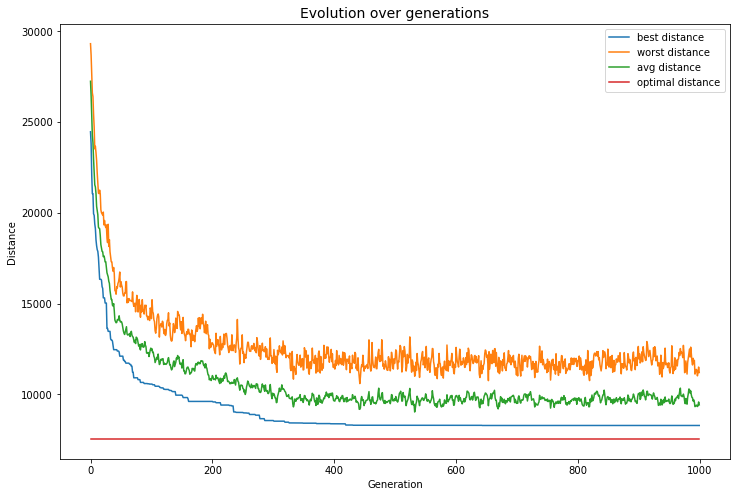

In [38]:
main_memetic(berlin52_problem, berlin52_solution, 1000)

In [36]:
# Run Memetic Algorithm multiple times to account for variance between runs
# Note: this can take a while (~12 minutes)
berlin52_best_memetic = multiple_runs_memetic(berlin52_problem, 1000)


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [40:53<00:00, 245.35s/it]


In [37]:
print("Best over runs:", berlin52_best_memetic)
print("Mean:", np.mean(berlin52_best_memetic))
print("Standard deviation:", np.std(berlin52_best_memetic))

Best over runs: [8105, 8005, 8086, 8183, 8195, 8086, 7995, 7998, 7944, 8089]
Mean: 8068.6
Standard deviation: 78.34692080739357


### TSP: st70

--- TSP problem information ---
Name:  st70
Comment:  70-city problem (Smith/Thompson)
Dimension:  70
Edge weight type:  EUC_2D
Optimal solution:  675


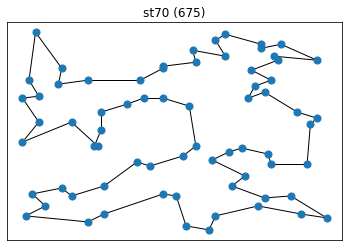

In [27]:
st70_problem, st70_solution = load_TSP('data/st70.tsp', 'data/st70.opt.tour')

**Evolutionary Algorithm**

===== Generation 1 =====
Best:  3181
Worst:  4133
Average:  3666.41


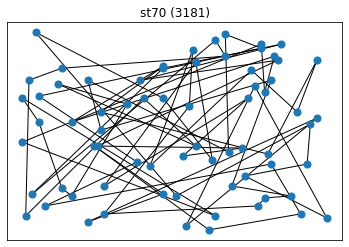

===== Generation 200 =====
Best:  1339
Worst:  1659
Average:  1474.77


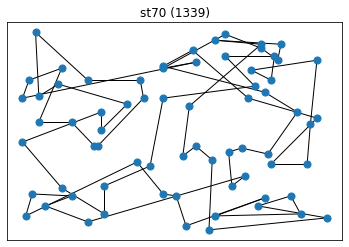

===== Generation 400 =====
Best:  1155
Worst:  1536
Average:  1332.07


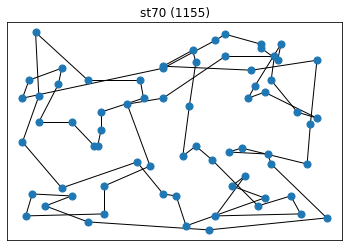

===== Generation 600 =====
Best:  1007
Worst:  1409
Average:  1180.03


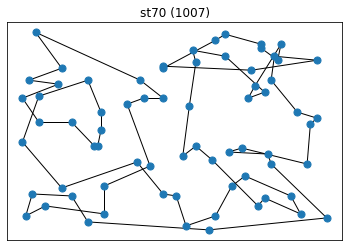

===== Generation 800 =====
Best:  926
Worst:  1233
Average:  1058.31


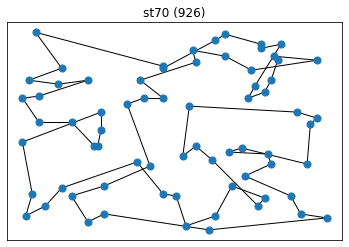

===== Generation 1000 =====
Best:  874
Worst:  1248
Average:  1034.15


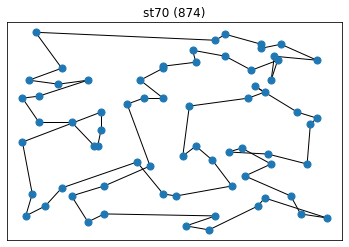

Elapsed time: 35.27s


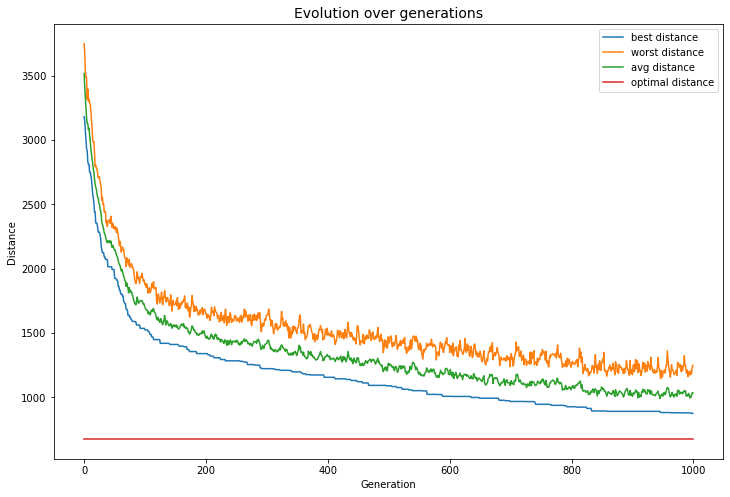

In [28]:
main(st70_problem, st70_solution, 1000)

In [29]:
# Run EA multiple times to account for variance between runs
st70_best = multiple_runs(st70_problem, 1000)

 10%|████████▎                                                                          | 1/10 [00:40<06:07, 40.79s/it]

KeyboardInterrupt: 

In [ ]:
print("Best over runs:", st70_best)
print("Mean:", np.mean(st70_best))
print("Standard deviation:", np.std(st70_best))

**Memetic**

Fewer generations are used because of run time and it seems that the memetic variant stagnates earlier anyway.

In [ ]:
main_memetic(st70_problem, st70_solution, 500)

In [ ]:
# Run Memetic Algorithm multiple times to account for variance between runs
# Note: this can take a while (~15 minutes)
st70_best_memetic = multiple_runs_memetic(st70_problem, 500)

In [ ]:
print("Best over runs:", st70_best_memetic)
print("Mean:", np.mean(st70_best_memetic))
print("Standard deviation:", np.std(st70_best_memetic))